In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split

In [ ]:
# Directories containing the images
normal_dir = '/content/drive/MyDrive/Final Project/Datasets/Prem/Train/normal'  # Path to the folder with normal images
tuberculosis_dir = '/content/drive/MyDrive/Final Project/Datasets/Prem/Train/tuberculosis'  # Path to the folder with tuberculosis images

In [ ]:
# Define image dimensions and batch size
img_height, img_width = 128, 128
batch_size = 32

In [ ]:
# 1. Data Loading and Preprocessing for Tuberculosis Prediction
def load_data(normal_dir, tuberculosis_dir, img_height=128, img_width=128):
    normal_images = []
    tuberculosis_images = []

    # Load normal images
    for filename in os.listdir(normal_dir):
        img = tf.keras.preprocessing.image.load_img(
            os.path.join(normal_dir, filename), target_size=(img_height, img_width))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        normal_images.append(img_array)

    # Load tuberculosis images
    for filename in os.listdir(tuberculosis_dir):
        img = tf.keras.preprocessing.image.load_img(
            os.path.join(tuberculosis_dir, filename), target_size=(img_height, img_width))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        tuberculosis_images.append(img_array)

    # Convert to numpy arrays and assign labels
    X_normal = np.array(normal_images)
    X_tuberculosis = np.array(tuberculosis_images)

    y_normal = np.zeros(X_normal.shape[0])  # Label 0 for normal
    y_tuberculosis = np.ones(X_tuberculosis.shape[0])  # Label 1 for tuberculosis

    X = np.concatenate([X_normal, X_tuberculosis], axis=0)
    y = np.concatenate([y_normal, y_tuberculosis], axis=0)

    return train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Load the data
X_train, X_test, y_train, y_test = load_data(normal_dir, tuberculosis_dir)

In [ ]:
# 2. Define GAN for Data Augmentation
def build_generator():
    model = models.Sequential([
        layers.Dense(128 * 32 * 32, activation="relu", input_dim=100),
        layers.Reshape((32, 32, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", activation="relu"),
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same", activation="relu"),
        layers.Conv2D(3, (7, 7), activation="tanh", padding="same")
    ])
    return model

def build_discriminator():
    model = models.Sequential([
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding="same", input_shape=(img_height, img_width, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

In [ ]:
# Build and compile GAN
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(0.0002, 0.5), metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
# GAN model
z = layers.Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
gan = models.Model(z, valid)
gan.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(0.0002, 0.5))

In [ ]:
# Training function for GAN
def train_gan(generator, discriminator, gan, epochs=50, batch_size=32):
    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_images = generator.predict(noise)

        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(gen_images, fake_labels)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_y)

        # Print the progress
        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {0.5 * np.add(d_loss_real, d_loss_fake)}] [G loss: {g_loss}]")

In [ ]:
# Train the GAN model
train_gan(generator, discriminator, gan)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: [23.501911  0.25    ]] [G loss: [array(15.899086, dtype=float32), array(15.899086, dtype=float32), array(0.28125, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


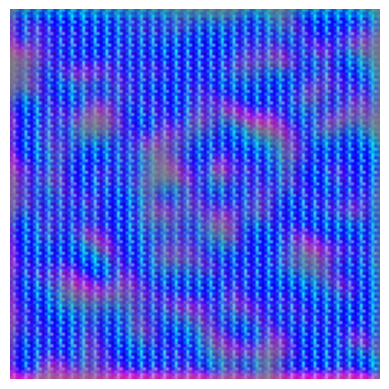

In [ ]:
import matplotlib.pyplot as plt

def display_generated_image(generator, latent_dim=100):
    # Generate a random noise vector
    noise = np.random.normal(0, 1, (1, latent_dim))

    # Use the generator to create an image
    generated_image = generator.predict(noise)

    # Rescale the image from [-1, 1] to [0, 1]
    generated_image = 0.5 * generated_image + 0.5

    # Display the generated image
    plt.imshow(generated_image[0])
    plt.axis('off')
    plt.show()

# Display a GAN-generated image
display_generated_image(generator)

In [ ]:
# Data augmentation using GAN-generated images
def generate_synthetic_images(generator, num_samples=500):
    noise = np.random.normal(0, 1, (num_samples, 100))
    return generator.predict(noise)

In [ ]:
# Add synthetic images to training data
synthetic_images = generate_synthetic_images(generator)
synthetic_labels = np.ones(synthetic_images.shape[0])

X_train_augmented = np.concatenate([X_train, synthetic_images], axis=0)
y_train_augmented = np.concatenate([y_train, synthetic_labels], axis=0)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step


In [ ]:
# 3. CNN Model for Tuberculosis Classification
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
cnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Train the CNN on augmented dataset
cnn_model.fit(X_train_augmented, y_train_augmented, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.7010 - loss: 43.6373 - val_accuracy: 1.0000 - val_loss: 2.6278e-12
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9065 - loss: 0.1957 - val_accuracy: 1.0000 - val_loss: 7.3034e-09
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9451 - loss: 0.1248 - val_accuracy: 1.0000 - val_loss: 7.8343e-10
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9546 - loss: 0.1078 - val_accuracy: 1.0000 - val_loss: 2.0163e-09
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9677 - loss: 0.0793 - val_accuracy: 1.0000 - val_loss: 5.1540e-09
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9782 - loss: 0.0727 - val_accuracy: 1.0000 - val_loss: 8.6265e-10
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9812 - loss: 0.0562 - val_accuracy: 1.0000 - val_loss: 5.1276e-10
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9884 - loss: 0.

In [ ]:
# Evaluate the CNN model
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9520 - loss: 0.2166
Test Accuracy: 96.20%


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


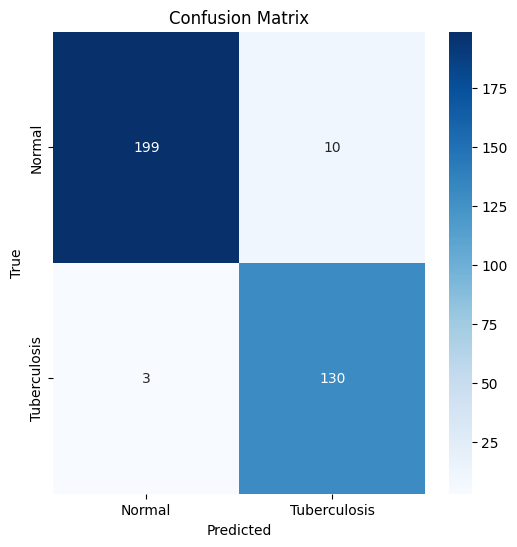

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Predict on test set
y_pred = cnn_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Tuberculosis"], yticklabels=["Normal", "Tuberculosis"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# 2. Classification Report
class_report = classification_report(y_test, y_pred, target_names=["Normal", "Tuberculosis"])
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.95      0.97       209
Tuberculosis       0.93      0.98      0.95       133

    accuracy                           0.96       342
   macro avg       0.96      0.96      0.96       342
weighted avg       0.96      0.96      0.96       342



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


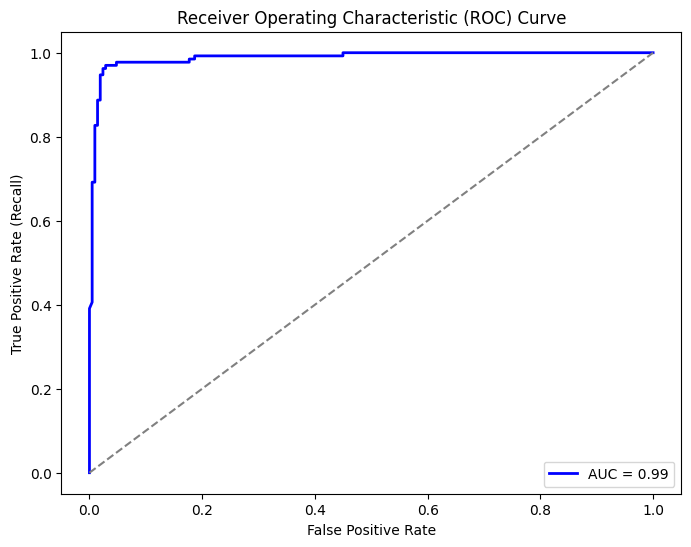

In [ ]:
# 3. AUC Curve (Receiver Operating Characteristic Curve)
fpr, tpr, thresholds = roc_curve(y_test, cnn_model.predict(X_test))
roc_auc = auc(fpr, tpr)

# Plot AUC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save the CNN model
cnn_model.save('cnn_model_tuberculosis.h5')
print("CNN Model saved as cnn_model_tuberculosis.h5")

CNN Model saved as cnn_model_tuberculosis.h5


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path, img_height=128, img_width=128):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)  # Convert the image to an array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image to [0, 1]
    return img_array

# Function to make predictions on a single image
def predict_image(model, image_path):
    img_array = load_and_preprocess_image(image_path)
    prediction = model.predict(img_array)  # Predict the class probabilities
    class_prediction = (prediction > 0.5).astype("int32")  # Convert probabilities to binary labels
    return class_prediction[0][0], prediction[0][0]  # Return predicted class (0 or 1) and probability

# Example usage
image_path = '/content/drive/MyDrive/Final Project/Datasets/Prem/Validation/Tuberculosis/Tuberculosis-2.png'  # Specify the path to the image you want to predict

# Make a prediction on the image
predicted_class, predicted_probability = predict_image(cnn_model, image_path)

# Output the result
if predicted_class == 0:
    print(f"The image is predicted to be Normal")
else:
    print(f"The image is predicted to have Tuberculosis")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
The image is predicted to have Tuberculosis
